# Theoretical Modelling coursework

In [1]:
import numpy as np
import pandas as pd
import simtools3 as st
import matplotlib.pyplot as plt
import matplotlib
import pyqtgraph as pg
from ipywidgets import interact, interactive,fixed
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import h5py

/home/k1455023/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def function_plot(X,Y,title,xlabel,ylabel):
    
    matplotlib.rcParams.update({'font.size': 22})
    
    fig = plt.figure(figsize=(14,6))

    plt.plot(X,Y,linewidth=.8);
    plt.title(title)
    plt.xlabel(xlabel, fontsize = 18)
    plt.ylabel(ylabel, fontsize = 25)
    #pp.savefig()

## Considering true and effective potentials

True potential:

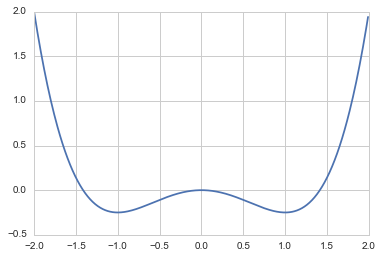

In [3]:
def phi(x):
    return -(1.0/2)*np.power(x,2)+(1.0/4)*np.power(x,4)
x=np.arange(-2,2,0.01)
plt.plot(x,phi(x))

In [4]:
%%latex
Variational Gaussian approximating potantial
\[\phi_{eff}(x_i)=\frac{1}{2}\left[\delta x^2_i(\tau) \,(1-3 C_{ii})\right] \]
where  \(\delta x_i(\tau) = x_i(\tau) - \mu_i(\tau)\)

<IPython.core.display.Latex object>

<function __main__.plot_phi_eff>

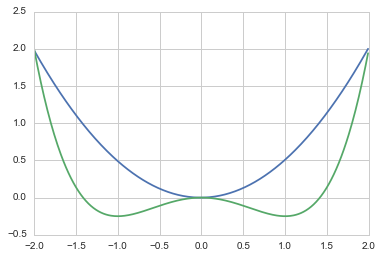

In [5]:
def phi_eff(x,mu,c):
    return (1.0/2)*(np.power((x-mu),2)*(1-3*c))

def plot_phi_eff(mu,c):
    x=np.arange(-2,2,0.01)
    plt.plot(x,phi_eff(x,mu,c))
    plt.plot(x,phi(x))
    #plt.xlim([-5,5])

interact(plot_phi_eff,mu=(-2,2,0.01),c=(0,1,0.01))

## Set up model parameters

### Initial conditions
- LNA requires initial conditions are deterministic
- Start with half at 1, half at -1

### $N$ (system size)
Set up with 20 particles, step up to 100 for actual analysis.
General considerations:
- smaller N for studying oscillations in transience
- Larger N for analysing performance of different methods

### $T$ (noise)
- LNA only really valid for small times but would like to capture point at which it becomes invalid. 
- Should do range of a couple of orders of magnitude
- Use $0.0 \leq T \leq 1.0$ at intervals of $0.01$

### $J$ (interaction amplitudes)
- Should affect variances, look at across 2 orders of magnitude
- Try $0.1 \leq J \leq 10$

### Number of replicas
- To be determined from standard error on mean. Would like to have SEM less than, for example 0.01. Just used to give robustness on estimate of true mean.

### $\Delta$ (time interval) 
- $\bar{\xi}_i \sim (2T\Delta)^{1/2}$ would like noise to be of order  $1 \implies \Delta \sim \frac{1}{2T}$. 
- Rather than varying delta as a function of temperature, I note that for the temperature regime under consideration $(0.01 \leq T \leq 1.0)$ in order to keep the noise of order $1$, we should only require that $\Delta \leq 0.5 \sim 0.1$. 
- I will therefore simulate $\Delta=0.01$ to err on the side of caution. I will then run one simulation batch at $\Delta=0.005$ (i.e. half the time interval) to confirm results remain unchanged.

### $t$ (system time)
- To be determined based on time taken for transience effects to die away
- Look at how long it takes for correlation with initial conditions to die away, e.g. $\frac{1}{N} \sum_i \langle x_i(0)x_i(\tau) \rangle$ where average is taken over particles

In [10]:
p={'N' : 50, 'R' : 10, 'x0': 1.0, 't' : 1000, 'dt' : 0.01, 'eta': 0.0}
Tinfo={'Tmin': 0, 'Tmax': 0.1, 'Tint':0.01}
jamp_info={'jampmin': 0, 'jampmax': 1, 'jampint':0.1}
#dbase_path= '/home/k1455023/CANES/theoretical_modelling/dbase'
dbase_path = '/run/media/k1455023/2842-168F/theoretical_modelling/dbase'

In [11]:
exp = st.Experiment(dbase_path,p,Tinfo,jamp_info,No_Jruns=2,save_ival=10)

## Look at time dependence

In [8]:
j=1

timesVStemp = pd.DataFrame(columns=('Gaussian', 'LNA'))

for T in T_range:
    p={'T' : T,'J' : j,'N' : n,'dt' : delta,'t' : time,'R' : replicas,'x0': x0amp,'e':eta}
    e = Experiment(dbase_path,p)
    timesVStemp.loc[str(T)]=[e.Gaussian.getRunDur(),e.LNA.getRunDur()]
        

NameError: name 'T_range' is not defined

In [ ]:
timesVStemp.plot()

## Look at trajectory means

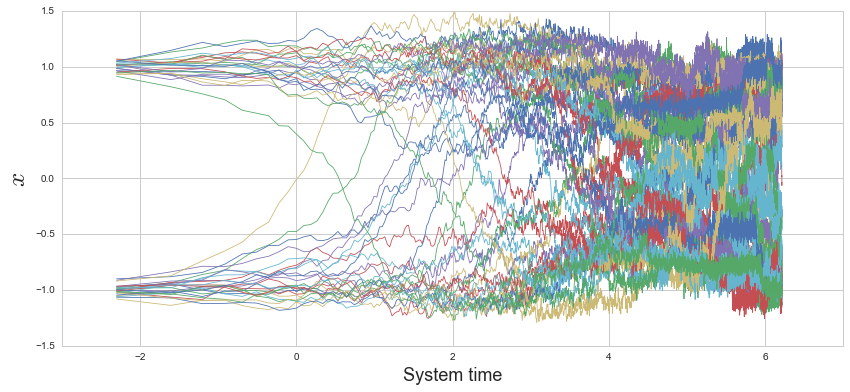

In [15]:
def show_timeseries(e,T,jamp,run,method,max_timestep):
    Tindex = np.where(e.Tarray==T)[0][0]
    jampindex = np.where(e.jamparray==jamp)[0][0]
    
    a = e.runs[run].simulations[Tindex][jampindex].getMean(method)
    times = e.times
    function_plot(np.log(times[:max_timestep]),np.transpose(a[:,:max_timestep]),'','System time',r'$x$')
    
    #fig = plt.figure(figsize=(14,6))
    #plt.plot(np.transpose(a),xdata=times,linewidth=.8);
interact(show_timeseries,e=fixed(exp),T=(0.01,0.10,0.01),jamp=(0,1,0.1),run=(0,1,1),
         method=['G','L','D'],max_timestep=(10,10000,10))
    

## Standard error of the mean

In [53]:
%%latex
#http://davidmlane.com/hyperstat/A103735.html
Standard error of the mean (SEM) is the standard deviation of the sampling 
distribution of the mean, given by:
\[\sigma_M = \frac{\sigma}{\sqrt{N}}\]
where \(\sigma\) is the standard deviation of the original distribution and 
N is the sample size (the number of scores each mean is based upon).
l

<IPython.core.display.Latex object>

In [ ]:
def plot_mean_errors(particle,max_time,T,J):
    df = compare_errors(particle,max_time,T,J)
    df.columns=['Gaussian','LNA','Direct','l','u']
    
    styles = ['-','-','-','--','--']
    colours = ['cornflowerblue','salmon','grey','grey','grey']
        
    ax = df.plot(style=styles,color=colours,linewidth=1.2,figsize=(14,6))
    lines, labels = ax.get_legend_handles_labels()
    
    ax.legend(lines[:3], labels[:3], loc='best')

interact(plot_mean_errors,particle='1',max_time=(0,5000,100),T=(0.01,0.10,0.01),J=(0,1,0.1))

In [ ]:
def show_mean_hist_at_t(T,J,t):
    p= {'T' : T,'J' : J,'N' : n,'dt' : delta,'t' : time,'R' : replicas,'x0': x0amp,'e':eta}
    e= Experiment(dbase_path,p)
    Dmeans = e.Direct.getMean()[:,t]
    Gmeans = e.Gaussian.getMean()[:,t]
    Lmeans = e.LNA.getMean()[:,t]
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharex=True,sharey=True)
    fig.set_size_inches(14, 6)
    ax1.hist(Dmeans,bins=20,color='grey',linewidth=.8)
    ax1.set_title('Direct')
    
    ax2.hist(Gmeans,bins=20,color='cornflowerblue',linewidth=.8)
    ax2.set_title('Gaussian')
    
    ax3.hist(Lmeans,bins=20,color='salmon',linewidth=.8)
    ax3.set_title('LNA')
    
    fig.subplots_adjust(wspace=0.1)

interact(show_mean_hist_at_t,T=(0.01,0.10,0.01),J=(0,1,0.1),t=(0,5000,100))

## Deviation of estimations from the true mean

In [54]:
%%latex
Define deviation from the mean as:
\[\epsilon \mu_i(\tau) = \left|\mu_i(\tau) - \mu_i^{approx}(\tau)\right|\]

<IPython.core.display.Latex object>

In [16]:
def make_mean_dev_variance_scatter(method,T,J,t):
    p= {'T' : T,'J' : J,'N' : n,'dt' : delta,'t' : time,'R' : replicas,'x0': x0amp,'e':eta}
    e= Experiment(dbase_path,p)
    
    mDev = eval('e.get'+method+'MeanDeviation()')[:,t]
    trueVar = e.Direct.getVar()[:,t]
    
    
    mu = pd.DataFrame(mDev,index=np.arange(0,p['N'],1),columns=['Dev_from_Mean'])
    var = pd.DataFrame(trueVar,index=np.arange(0,p['N'],1),columns=['True_var'])
    
    df = mu.join(var)
    p = sns.regplot('Dev_from_Mean','True_var',df)

interact(make_mean_dev_variance_scatter,method=['Gaussian','LNA'],T=(0.01,0.10,0.01),J=(0,1,0.1),t=(0,5000,100))

NameError: global name 'n' is not defined

<function __main__.make_mean_dev_variance_scatter>

## Mean squared error
let $\bar{x}_i(\tau)$ be the true mean and $\hat{x}_i(\tau)$ be the approximating mean at time $\tau$, then $MSE(\tau) = \frac{1}{N} \sum_i \left(\hat{x}_i(\tau) - \bar{x}_i(\tau)\right)^2$

In [17]:
def PlotAveMeanError(e,T,jamp,max_timestep):
    Tind = e.getTindex(T)
    jampind = e.getjampindex(jamp)
    Gmean = e.getAveOverJ('mean_error','G',verbose=False)[Tind][jampind]
    Lmean = e.getAveOverJ('mean_error','L',verbose=False)[Tind][jampind]
    
    aveGmean= np.mean(Gmean,axis=0) # averages over particles
    aveLmean= np.mean(Lmean,axis=0)
    
    res = np.transpose(np.vstack((aveGmean[:max_timestep],
                                aveLmean[:max_timestep])))
    function_plot(e.times[:max_timestep],res,'','System time','Average MSE on mean');
    
interact(PlotAveMeanError,e=fixed(exp),T=(0,0.10,0.01),jamp=(0,1,0.1),
        max_timestep=(10,10000,10))

KeyError: 'Unable to open object (Component not found)'

## Deviation of estimations from true variance

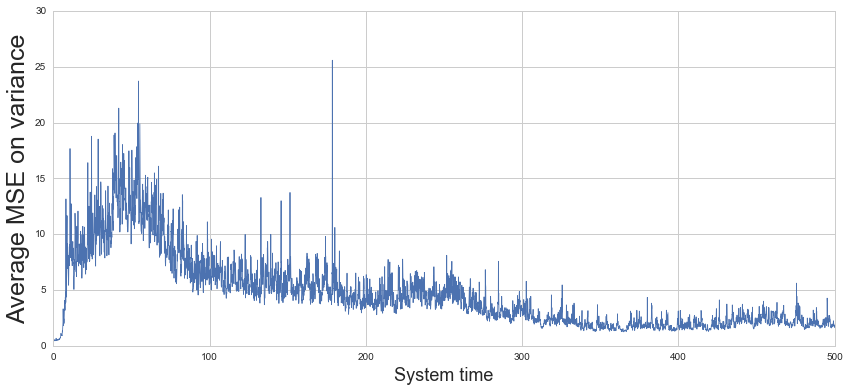

In [62]:
def PlotAveVarError(e,T,jamp,max_timestep):
    Tind = e.getTindex(T)
    jampind = e.getjampindex(jamp)
    Gvar = e.getAveOverJ('variance_error','G',verbose=False)[Tind][jampind]
    #var = e.getAveOverJ('mean_error','L',verbose=False)[Tind][jampind]
    
    aveGvar= np.mean(Gvar,axis=0) # averages over particles
    #veLmean= np.mean(Lmean,axis=0)
    
    #es = np.transpose(np.vstack((aveGmean[:max_timestep],
    #                           aveLmean[:max_timestep])))
    function_plot(e.times[:max_timestep],aveGvar[:max_timestep],'',
                  'System time','Average MSE on variance');
    
interact(PlotAveVarError,e=fixed(exp),T=(0,0.10,0.01),jamp=(0,1,0.1),
        max_timestep=(10,10000,10))

In [63]:
%%latex 
Define relative deviation from the true variance as:
\[\epsilon Var(x_i) = \frac{\left|\langle (\delta \hat{x}_i)^2 \rangle - \langle (\delta x_i)^2 \rangle \right|}{\langle (\delta x_i)^2 \rangle}\]
where \(\langle (\delta \hat{x}_i)^2 \rangle\) is the estimated variance.

<IPython.core.display.Latex object>

## Scatter plots of true vs approximating means

In [18]:
def get_scatter_df_per_param(e,T,jamp,run,t):
    Tind = e.getTindex(T)
    jampind = e.getjampindex(jamp)
    sim = e.runs[run].simulations[Tind][jampind]
    d = np.transpose(np.vstack((sim.getMean('G')[:,t],sim.getMean('L')[:,t],
                   sim.getMean('D')[:,t])))
    dat = pd.DataFrame(d,index=[np.arange(np.shape(d)[0])],
                       columns=['Gaussian','LNA','Direct'])
   
    approx= dat[['Gaussian','LNA']].stack(level=-1, dropna=True).reset_index()
   
    res = approx.join(dat['Direct'], on='level_0')[['level_1',0,'Direct']]
    res.columns=['Approx Method','Approx Value','Direct Value']
    return res

def get_scatter_df(e,Ts,jamps,run,t):
    res = pd.concat([get_scatter_df_per_param(e,T,jamp,run,t) for T in Ts for jamp in jamps], 
    keys = [tuple([str(T),str(jamp)]) for T in Ts for jamp in jamps],names=['T','jamp'])
    return res

def plot_scatter(e,Ts,jamps,run,t):
    dat = get_scatter_df(e,Ts,jamps,run,t).reset_index()
    
    g = sns.FacetGrid(dat,row = 'T', col='jamp',hue='Approx Method',size=3)
    g.map(plt.scatter,'Approx Value','Direct Value').set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
    g.add_legend()
    x=np.arange(-1.5,1.5,0.01)
    y = x
    for i in range(3):
        for j in range(3):
            g.axes[i][j].plot(x,y,color='black',lw=.5,ls='--')

/home/k1455023/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


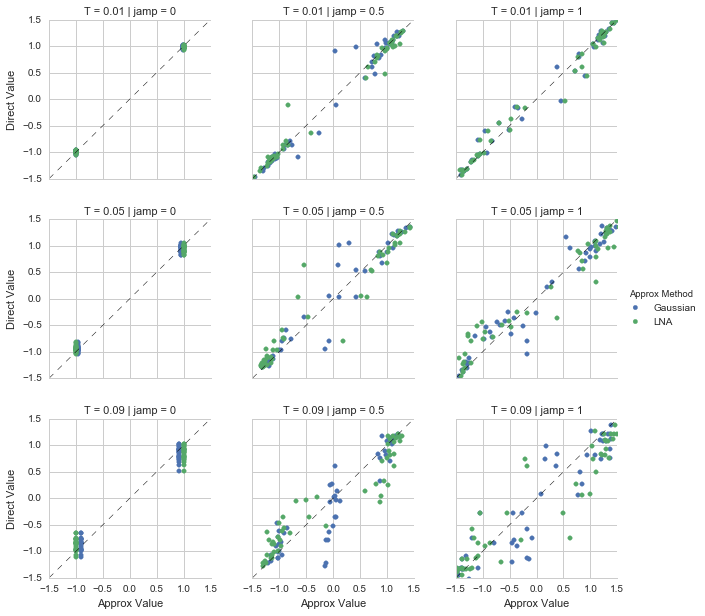

In [19]:
plot_scatter(exp,[0.01,0.05,0.09],[0,0.5,1],1,50)

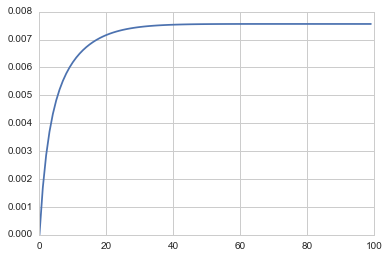

In [21]:
time=100
LvarEG= [exp.runs[1].simulations[1][2].getVar('L')[1][i] for i in range(time)]
plt.plot(np.arange(time),LvarEG)

In [ ]:
n=5; jamp=1; eta=0;
